## Active Contours using Level Sets

Dans ce TP, nous allons nous intéresser à la segmentation d'image par la méthode "Level Set". 

In [1]:
from __future__ import division

import scipy as scp
import numpy as np
import pylab as pyl
import matplotlib.pyplot as plt

from nt_toolbox.general import *
from nt_toolbox.signal import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Managing level set functions

Dans la partie "Active Contours using parametric curves", nous avons représenté une courbe comme : $f(p) : S^1 \rightarrow \mathbb{R}^2$, dépendante d'un paramètre $p$. Pour chacun des $p$, nous avions un point de la courbe.

Désormais, nous allons représenter une courbe de façon implicite. Ce sont tous les points, c'est à dire tous les plans, satisfaisant une certaine équation égale à 0.
$$ \gamma = \{(x,y) | \varphi(x,y) = 0\} $$

Une courbe fermée définit une forme. La courbe du contour correspond aux points où $\varphi(x,y) = 0$. A l'extérieur du contour, nous aurons alors $\varphi < 0$ et $\varphi > 0$ à l'intérieur par exemple.

On commence par définir une grille sur laquelle nous travaillerons ensuite.

In [2]:
#discrétisation de taille nxn du domaine [0,1]²
n = 200
Y,X = np.meshgrid(np.arange(1,n+1), np.arange(1,n+1))

On pose $\varphi_{1}$ la fonction qui à (x,y) associe la distance entre (x,y) et le cercle de centre c et de rayon r.

In [3]:
r = n/3. #rayon du cercle

In [4]:
c = np.array([r,r]) + 10 #centre du cercle

In [5]:
phi1 = np.sqrt((X-c[0])**2 + (Y-c[1])**2) - r

#### Exercise 1 Load a square shape $\varphi_{2}$ at a different position for the center.

Nous allons définir une nouvelle fonction $\varphi_{2}$ qui sera un carré dont le centre est différent de celui précédemment défini pour le cercle.

In [6]:
#nouvelle position du centre
c = - np.array([r,r]) - 10 + n 

#pour avoir un carré : on fonctionne avec les valeurs absolues
A = abs(X-c[0]) 
B = abs(Y-c[1])
phi2 = np.maximum(A,B) - r

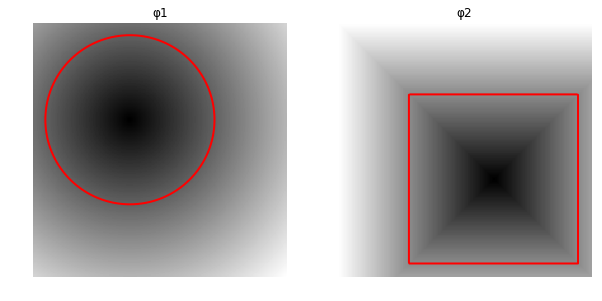

In [7]:
from nt_toolbox.plot_levelset import *
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plt.title("φ1")
plot_levelset(phi1)

plt.subplot(1,2,2)
plt.title("φ2")
plot_levelset(phi2)

#### Exercise 2 : Compute the intersection and the union of the two shapes. Store the union in $\varphi_{0}$ that we will use in the remaining part of the tour.

Nous allons maintenant calculer l'union et l'intersection des deux courbes précédentes (le cercle et le carré). Pour avoir l'union, on calcule la fonction minimum entre $\varphi_{1}$ et $\varphi_{2}$. Pour connaître l'intersection, il faut donc calculer la fonction maximum.

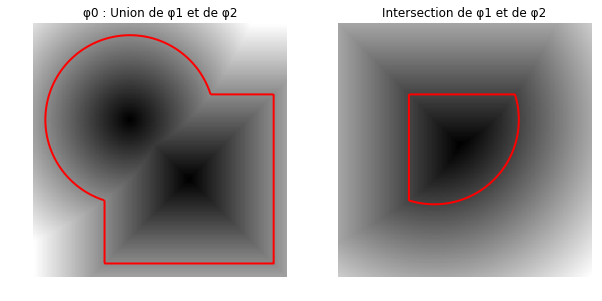

In [8]:
plt.clf
plt.figure(figsize = (10,5))

#définition de phi0 par l'union, ie: le minimum
phi0 = np.minimum(phi1,phi2)

#union, ie : min
plt.subplot(1,2,1)
plt.title("φ0 : Union de φ1 et de φ2")
plot_levelset(phi0)

#intersection, ie : max
plt.subplot(1,2,2)
plt.title("Intersection de φ1 et de φ2")
plot_levelset(np.maximum(phi1,phi2))

### Mean Curvature Motion

Comme dans le TP "Active contours using parametric curves", on utilise la notion de courbure moyenne. On pose $\varphi_{t}$ une famille de courbes de niveaux paramétrées par un temps artificiel t, qui satisfait l'EDP suivante, aussi appelée équation du Mean Curvature Motion :

$$ \frac{\partial\varphi_{t}}{\partial t}=-G(\varphi_{t}) $$ avec $$ G(\varphi)=-\|\nabla\varphi\| div\left(\frac{\nabla\varphi}{\|\nabla\varphi\|}\right) $$


L'idée est de déterminer $\varphi$ par une descente de gradient :
$$ \varphi^{(l+1)}=\varphi^{(l)}-\tau G(\varphi^{(l)}) $$
avec $\tau>0$ et assez petit. 

In [9]:
#Temps max pour l'évolution
Tmax = 200 
#intervalle de temps
tau = .5 
#nombre maximal d'itérations
niter = int(Tmax/tau) 

In [10]:
#initialisation de φ à l'instant 0 de la descente de gradient
phi = np.copy(phi0) 

Tous les éléments de l'équation précédente ont besoin d'être déterminés. Pour commencer, on calcule le gradient $\nabla\varphi$ en utilisant la méthode des différences finies :

In [11]:
from nt_toolbox.grad import *
#calcul du gradient
#order = 2 : utilisation du schéma centré
g0 = grad(phi, order=2) 

On passe au calcul de la norme du gradient $\|\nabla\varphi\|$ :

In [59]:
#donne le plus petit float tel que 1. + eps soit différent de 1.
eps = np.finfo(float).eps 
#norme du gradient
norm = np.sqrt(np.sum(g0**2, 2))
#max entre un float très petit et la norme du gradient : on obtient toujours la norme du gradient car dans notre cas,
# ses composantes sont plus grandes que eps. Cette commande peut servir à éviter qu'une des composantes du gradient 
# soit nulle.
d = np.maximum(eps*np.ones([n,n]),norm)

On calcule le gradient normalisé ce qui nous permet de connaître l'amplitude de la direction à choisir :

In [71]:
g = g0/np.repeat(d[:,:,np.newaxis], 2, 2)

Puis le terme de courbure $G$ :

In [67]:
from nt_toolbox.div import *
G = -1 * d * div(g[:,:,0], g[:,:,1], order=2)

On peut à présent effectuer la première étape de la descente du gradient :

In [15]:
phi = phi - tau*G

#### Exercise 3 Implement the mean curvature motion.

Nous allons maintenant implémenter la méthode vue précédemment. Pour cela, à chaque itération, on calcule le gradient de $\varphi$ ainsi que sa norme pour obtenir le gradient normalisé. A partir de ce dernier, le terme de courbure peut être calculé et on applique la descente du gradient. 

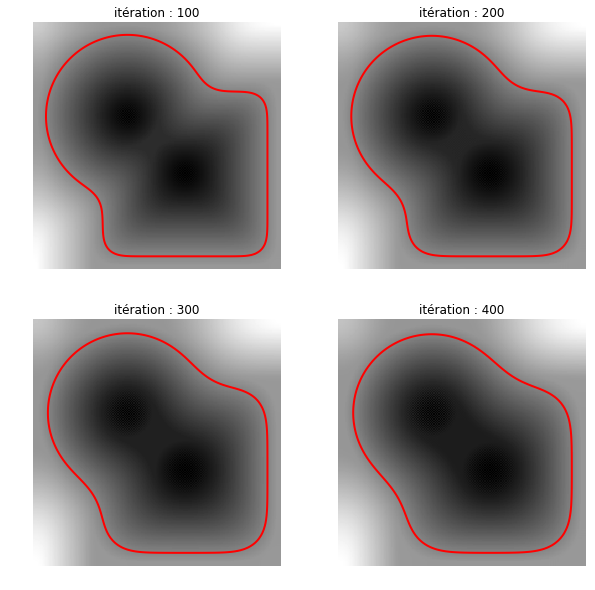

In [16]:
#pour avoir 4 sous-figures, on sépare les itérations en 4 sous-ensembles.
aff = np.arange(int(niter/4.),niter+1,int(niter/4.))

#initialisation
phi = np.copy(phi0)

plt.figure(figsize = (10,10))

k = 0
#algorithme du mean curvature motion tel que décrit précédemment
for i in range(1,niter+1):
    g0 = grad(phi, order=2)
    d = np.maximum(eps*np.ones([n,n]), np.sqrt(np.sum(g0**2, 2)))
    g = g0/np.repeat(d[:,:,np.newaxis], 2, 2)
    G = -1 * d * div(g[:,:,0], g[:,:,1], order=2)
    phi = phi - tau*G
    if i==aff[k]:
        #affichage de l'évolution de l'algorithme
        k = k+1 
        plt.subplot(2,2,k)
        plt.title("itération : "+str(i))
        plot_levelset(phi)


### Levelset Re-distancing

Faire Blabla

In [17]:
phi = phi0**3

In [18]:
from nt_toolbox.perform_redistancing import *
phi1 = perform_redistancing(phi0)

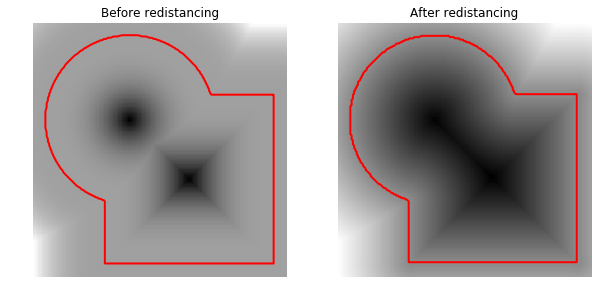

In [19]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plot_levelset(phi)
plt.title("Before redistancing")

plt.subplot(1,2,2)
plot_levelset(phi1)
plt.title("After redistancing")

plt.show()

# Pas de changement, bizarre non ?????

### Edge-based Segmentation with Geodesic Active Contour

Taille $n$ de l'image et téléchargement de l'image.

In [20]:
n = 200
f0 = rescale(load_image("nt_toolbox/data/cortex.bmp", n))

Calcul du gradient et sa magnitude.

In [21]:
g = grad(f0, order=2) #calcul du gradient
d0 = np.sqrt(np.sum(g**2, 2)) #magnitude

In [22]:
a = 5 #coefficient de floutage

In [23]:
from nt_toolbox.perform_blurring import *
d = perform_blurring(d0, np.asarray([a]),bound="per") #floutage

In [24]:
epsilon = 1e-1

In [25]:
W = 1./(epsilon + d)
W = rescale(-d, 0.1, 1) #redimensionnement

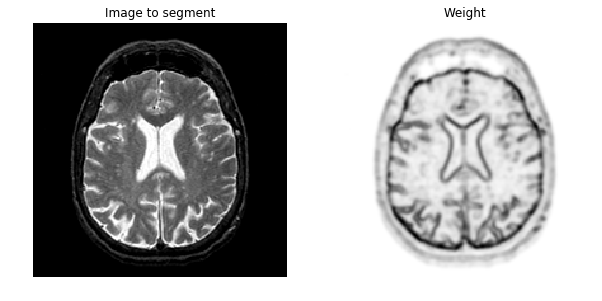

In [26]:
plt.figure(figsize=(10,5))
imageplot(f0, "Image to segment", [1,2,1])
imageplot(W, "Weight", [1,2,2])

#### Exercise 4 Compute an initial shape φ0 at time t=0, for instance a centered square.

On reprend les données du début de fichier puis on initialise la forme φ0.

In [27]:
#Données exo 1
Y,X = np.meshgrid(np.arange(1,n+1), np.arange(1,n+1))
r = n/3
c = np.array([r,r])/2 + r

#Forme initiale
phi0 = np.maximum(abs(X-c[0]),abs(Y-c[1])) - r

Affichage.

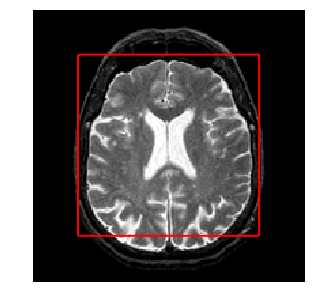

In [28]:
plt.figure(figsize=(5,5))
plot_levelset(phi0, 0, f0)

In [29]:
tau = .4 #pas
Tmax = 1500 #temps max
niter = int(Tmax/tau) #nombre d'itérations
phi = np.copy(phi0) #copie de phi0 dans phi

In [30]:
gW = grad(W, order=2) #gradient de W, ordre 2

#### Exercise 5 Compute and store in G the gradient G(φ)(right hand side of the PDE) using the current value of the distance function φ.

In [31]:
gD = grad(phi, order=2)
d = np.maximum(eps*np.ones([n,n]), np.sqrt(np.sum(gD**2, 2)))
#Normalisation
g = gD/np.repeat(d[:,:,np.newaxis], 2, 2)

#Gradient
G = -1 * W * d * div(g[:,:,0], g[:,:,1], order=2) - np.sum(gW*gD,2)

In [32]:
phi = phi - tau*G

In [33]:
phi = perform_redistancing(phi)

#### Exercise 6 Implement the geodesic active contours gradient descent. Do not forget to do the re-distancing.


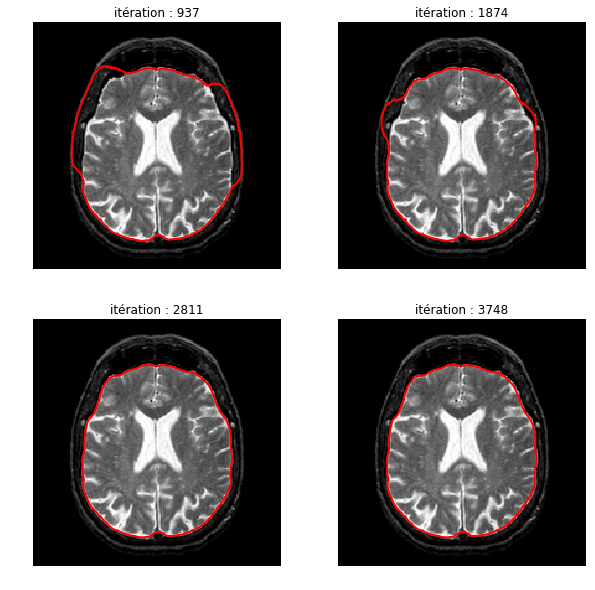

In [34]:
plt.figure(figsize=(10,10))

#Initialisation évolution
phi = phi0

k = 0
gW = grad(W,order=2)
for i in range(1,niter+1):
    gD = grad(phi,order=2)
    d = np.maximum(eps, np.sqrt(np.sum(gD**2,2)))
    g = gD/np.repeat(d[:,:,np.newaxis], 2, 2)
    G = W * d * div(g[:,:,0], g[:,:,1],order=2) + np.sum(gW*gD,2)
    phi = phi + tau*G
    if i%30==0 :
        phi = perform_redistancing(phi)
    if i % int(niter/4.) == 0:
        k = k+1
        plt.subplot(2,2,k)
        plt.title("itération : "+str(i))
        plot_levelset(phi,0,f0)

### Region-based Segmentation with Chan-Vese

#### Exercise 7 Compute an initial level set function φ0, stored in phi0, for instance many small circles.

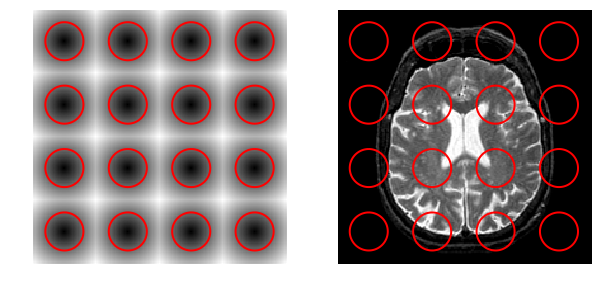

In [35]:
plt.figure(figsize=(10,10))

Y,X = np.meshgrid(np.arange(1,n+1), np.arange(1,n+1))
k = 4
r = .3*n/k #rayon
phi0 = np.zeros([n,n]) + np.float("inf")
for i in range(1,k+1):
    for j in range(1,k+1):
        c = (np.asarray([i,j])- 1)*(n/k) + (n/k)*.5
        phi0 = np.minimum(phi0, np.sqrt( abs(X-c[0])**2 + abs(Y-c[1])**2 ) - r )

plt.clf
plt.subplot(1,2,1)
plot_levelset(phi0)
plt.subplot(1,2,2)
plot_levelset(phi0,0,f0)

In [36]:
lambd = 2
c1 = .7
c2 = 0
tau = .5
Tmax = 100
niter = int(Tmax/ tau)

In [37]:
phi = np.copy(phi0)

#### Exercise 8 Compute this gradient G(φ) using the current value of the distance function.

In [38]:
gD = grad(phi,order = 2)
d = np.maximum(eps * np.ones([n,n]), np.sqrt(np.sum(gD**2,2)))
g = gD/np.repeat(d[:,:,np.newaxis], 2, 2)
#gradient
G = d * div( g[:,:,0],g[:,:,1],order=2) - lambd*(f0-c1)**2 + lambd*(f0-c2)**2;

In [39]:
phi = phi + tau*G

#### Exercise 9 Implement the full gradient descent.


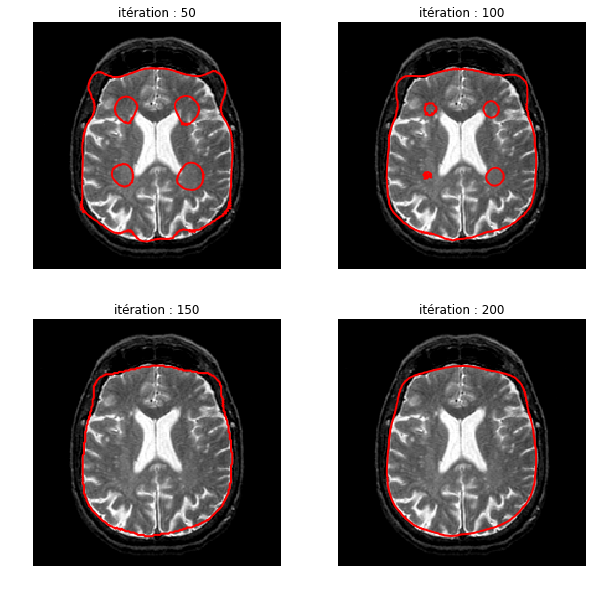

In [40]:
plt.figure(figsize=(10,10))

#intialisation
phi = np.copy(phi0)

k = 0
plt.clf
for i in range(1,niter+1):
    gD = grad(phi,order=2)
    d = np.maximum(eps*np.ones([n,n]), np.sqrt(np.sum(gD**2,2)) )
    g = gD/np.repeat(d[:,:,np.newaxis], 2, 2)
    G = d * div(g[:,:,0],g[:,:,1],order=2 ) - lambd*(f0-c1)**2 + lambd*(f0-c2)**2
    phi = phi + tau*G
    if i%30==0 :
        phi = perform_redistancing(phi)
    if i % int(niter/4)==0 :
        k = k+1
        plt.subplot(2,2,k)
        plt.title("itération : "+str(i))
        plot_levelset(phi,0,f0)